# The London Railway Network

The cell below defines the abstract class whose API you will need to impement. Do NOT modify it.

In [182]:
# DO NOT MODIFY THIS CELL

from abc import ABC, abstractmethod  

class AbstractLondonRailwayMapper(ABC):
    
    # constructor
    @abstractmethod
    def __init__(self):
        pass           
        
    # data initialisation
    @abstractmethod
    def loadStationsAndLines(self):
        pass

    # returns the minimum number of stops to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # numStops : int
    @abstractmethod
    def minStops(self, fromS, toS):     
        numStops = -1
        return numStops    
    
    # returns the minimum distance in miles to connect station "fromS" to station  "toS"
    # fromS : str
    # toS : str
    # minDistance : float
    @abstractmethod
    def minDistance(self, fromS, toS):
        minDistance = -1.0
        return minDistance
    
    # given an unordered list of station names, returns a new railway line 
    # (represented as a list of adjacent station names), connecting all such stations 
    # and such that the sum of the distances (in miles) between adjacent stations is minimised
    # inputList : set<str>
    # outputList : list<str>
    @abstractmethod
    def newRailwayLine(self, inputList):
        outputList = []
        return outputList

Use the cell below to define any data structure and auxiliary python function you may need. Leave the implementation of the main API to the next code cell instead.

In [183]:
# ADD YOUR DATA STRUCTURE DEFINITIONS AND HELPER CODE HERE
from math import cos, sin, radians, sqrt, atan2, pi

'''
harvensineDistance calculator
'''
def harvensineDistance(lat1, lng1, lat2, lng2):
    earthRadius = 3958.7613322984894 # earth's radius in miles
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    lng2 = radians(lng2)
    lng1 = radians(lng1)

    dLat = lat2-lat1;
    dLng = lng2-lng1;
    a = sin(dLat/2) * sin(dLat/2) + cos(lat1) * cos(lat2) * sin(dLng/2) * sin(dLng/2);
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    return earthRadius * c


def euclidean_distance(lat1, lng1, lat2, lng2):
    return sqrt((lat1-lat2) ** 2 + (lng1-lng2) ** 2)

class UnionFind:
    def __init__(self, size):
        #init
        self.id = []
        self.size =[]
        for i in range (10):
            self.id.append(i)
            self.size.append(1)

        #root
    def getRoot(self,i):
        root = i
        while root!=self.id[root]:
            root=self.id[root]
        # path compression
        # traverse and update when calling root when value is not same as root
        while i != root:
            next = self.id[i]
            self.id[i] = root
            i = next
        return root

    #find
    def find(self,u,v):
        return self.getRoot(u)==self.getRoot(v)


    #union
    def union(self,u,v):
        r_u=self.getRoot(u)
        r_v=self.getRoot(v)
        if r_u==r_v: return
        if self.size[r_u]<self.size[r_v]:
            self.id[r_u]=r_v
            self.size[r_v]+=self.size[r_u]
        else:
            self.id[r_v]=r_u
            self.size[r_u]+=self.size[r_v]
        

'''
Edge Representation in the graph
'''
class Edge:
    def __init__(self, v, w, weight):
        self.v = v
        self.w = w
        self.weight = weight

    def endPoint(self):
        return self.v

    def otherEndPoint(self, vertex):
        if vertex == self.v:
            return self.w
        return self.v

    def same(self, e):
        return self.v == e.endPoint() and self.w == e.otherEndPoint(e.endPoint()) and self.weight == e.getWeight()

    def getWeight(self):
        return self.weight

    def swap(self):
        return Edge(self.w, self.v, self.weight)
    
    def __str__(self):
        return f"v: {self.v}, w: {self.w}, weight: {self.weight}"
    
    def __eq__(self, other):
        return self.weight == other.weight
    
    def __ge__(self, other):
        return self.weight >= other.weight

    def __gt__(self, other):
        return self.weight > other.weight
    
    def __le__(self, other):
        return self.weight <= other.weight
    
    def __lt__(self, other):
        return self.weight < other.weight

'''
Graph Representation
'''

class Graph:

    def __init__(self, V):
        self.V = V
        self.adj = []
        for _ in range (0, V):
            self.adj.append([])

    def addEdge(self, e):
        v = e.endPoint()
        w = e.otherEndPoint(v)
        self.adj[v].append(e)
        # self.adj[w].append(e)
        # we have to swap here because we have to relax its outgoing edges, if we don't swap the direction around it would relax the wrong end
        self.adj[w].append(e.swap())

    def adjacencies(self, v):
        return self.adj[v]
    
class TSPGraph(Graph):

    def __init__(self, V, stations):
        super().__init__(V)
        self.stations = []
        self.__createCompleteGraph(stations)

    def getStationName(self, index):
        return self.stations[index].getName()
    
    def getStation(self, index):
        return self.stations[index]
    
    def getStations(self):
        return self.stations.copy()

    def __createCompleteGraph(self, inputStations):
        for index, currentStation in enumerate(inputStations):
            for createdStationIndex, createdStation in enumerate(self.stations):
                distance = euclidean_distance(self.stations[createdStationIndex].lat, self.stations[createdStationIndex].lng, currentStation.lat, currentStation.lng)
                self.addEdge(Edge(index, createdStationIndex, distance))
            self.stations.append(currentStation)
    
'''
BFS Algorithm
'''
class Queue():
    def __init__(self):
        self.queue = []
    
    def isEmpty(self):
        return self.queue == []
    
    def enqueue(self, item):
        self.queue.append(item)
    
    def dequeue(self):
        return self.queue.pop(0)
    def size(self):
        return len(self.queue)


class BFS:
    def __init__(self, G, s):
        self.starting = s
        self.distToSource = [-1 for v in range(0, G.V)]
        self.edgeTo = [-1 for v in range(0, G.V)]
        self.__bfs(G, s)

    def __bfs(self, G, s):
        q = Queue()
        q.enqueue(s)
        self.distToSource[s] = 0
        while(not q.isEmpty()):
            v = q.dequeue()

            for w in G.adjacencies(v):
                index = w.otherEndPoint(v)
                if (self.distToSource[index] == -1):
                    q.enqueue(index)
                    self.distToSource[index] = self.distToSource[v] + 1
                    self.edgeTo[index] = v
    
    def hasPathTo(self, v):
        return self.distToSource[v] != -1
    

    ## BFS calculates shortest path so this is the shortest path
    def pathTo(self, v):
        if (not self.hasPathTo(v)): return None

        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x]
        path.append(self.starting)
        return path


    ## BFS calculates shortest path so this is the shortest length
    def lengthTo(self, v):
        if (not self.hasPathTo(v)): return None

        return self.distToSource[v] 

    
    
class DFS:
    path = []
    x = []
    y = []
    def __init__(self, G, s, names):
        self.names = names
        self.starting = s
        self.marked = [False for v in range(0, G.V)]
        self.edgeTo = [-1 for v in range (0, G.V)]
        self.path.append(self.names[s].getName())
        self.getXY(self.names[s])
        self.__dfs(G,s)
    
    def __dfs(self, G, v):
        self.marked[v] = True
        for w in G.adjacencies(v):
            currentPoint = w.otherEndPoint(w.endPoint())
            if (not self.marked[currentPoint]):
                self.path.append(self.names[currentPoint].getName())
                self.getXY(self.names[currentPoint])
                self.__dfs(G,currentPoint)
                self.edgeTo[currentPoint] = v
                
    def getXY(self, station):
        self.x.append(station.lat)
        self.y.append(station.lng)
    
    def hasPathTo(self, v):
        return self.marked[v]

    # build the path backwards 
    def pathTo(self, v):
        if (not self.hasPathTo(v)): return None
        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x]
        path.append(self.starting)
        return path
    
    
'''priority queue'''
class MinPQ:

    def __init__(self):
        self.values = []
    
    def insert(self, value):
        self.values.append(value)
        self.__swim_up(len(self.values) - 1)

    def delMin(self):

        if len(self.values) == 0: 
            return None

        # swap the first and last element of the values
        self.__swap(0, len(self.values) - 1)
        output = self.values.pop()
        self.__sink(0)
        return output

    def size(self):
        return len(self.values)
    
    def contains(self, targetValue):
        for value in self.values:
            if value == targetValue:
                return True
        return False

    def isEmpty(self):
        return self.size() == 0


    def __sink(self, targetIndex):
        
        queueSize = len(self.values)


        while True:
            leftIndex = 2 * targetIndex + 1
            rightIndex = 2 * targetIndex + 2

            smaller = leftIndex

            if rightIndex < queueSize and self.values[rightIndex] < self.values[smaller]:
                smaller = rightIndex
            
            # needs to be >= here because the case of just two values
            if leftIndex >= queueSize or self.values[smaller] > self.values[targetIndex]:
                break

            self.__swap(smaller, targetIndex)
            targetIndex = smaller

    def decreaseKey(self, targetValue, priority):
            index = 0
            for value in self.values:
                if value == targetValue:
                    value.priority = priority
                    self.__swim_up(index)
                    # self.__sink(index)
                index += 1


    def __swim_up(self, targetIndex):
        parent_index = (targetIndex - 1) // 2

        while self.values[targetIndex] < self.values[parent_index] and targetIndex > 0:

            self.__swap(parent_index, targetIndex)

            targetIndex = parent_index
            parent_index = (targetIndex - 1) // 2


    def __swap(self, firstIndex, secondIndex):
        tmp = self.values[firstIndex]
        self.values[firstIndex] = self.values[secondIndex]
        self.values[secondIndex] = tmp

class PQItem:
    def __init__(self, name, priority):
        self.name = name
        self.priority = priority
    
    def __eq__(self, name):
        return self.name == name
    
    def __ge__(self, other):
        return self.priority >= other.priority

    def __gt__(self, other):
        return self.priority > other.priority
    
    def __le__(self, other):
        return self.priority <= other.priority
    
    def __lt__(self, other):
        return self.priority < other.priority

class Dijkstra:

    def __init__(self, G, s):
        self.edgeTo = [None for v in range (0, G.V)]
        # -1 for infinity since weight cannot be negative
        self.distTo = [-1 for v in range(0, G.V)]
        self.distTo[s] = 0


        self.pq = MinPQ()
        self.pq.insert(PQItem(s, 0))
        self.starting = s

        while not self.pq.isEmpty():
            v = self.pq.delMin().name
            for e in G.adjacencies(v):
                self.__relax(e)

    def __relax(self, e):
        v = e.endPoint()
        w = e.otherEndPoint(v)
        # print(w)
        if self.distTo[w] > self.distTo[v] + e.getWeight() or self.distTo[w] == -1:
            self.distTo[w] = self.distTo[v] + e.getWeight()
            self.edgeTo[w] = e

            if self.pq.contains(w):
                self.pq.decreaseKey(w, self.distTo[w])
                # print("will decrease key")
            else:
                self.pq.insert(PQItem(w, self.distTo[w]))
    # def hasPathTo(self, v):
    #     return self.distToSource[v] != -1
    
    def pathTo(self, v):
        path = []
        x = v
        while (x != self.starting):
            path.append(x)
            x = self.edgeTo[x].endPoint()
        path.append(self.starting)
        return path

    def lengthTo(self, v):
        return self.distTo[v] 

    
class NearestNeighbor:
    def __init__(self, G):
        self.bestScore = -1
        self.bestPaths = []
        self.marked = [False for _ in range(G.V)]
        for starting in range(G.V):
            self.uf = UnionFind(G.V)
            self.__nearestNeighbor(starting, G)
            print("\n\n")

    def __nearestNeighbor(self, v, G):
        vertexAmount = 0
        path = [G.getStationName(v)]
        x = [G.getStation(v).lat]
        y = [G.getStation(v).lng]
        score = 0

        currentVertex = v
        nextEdge = None
        while vertexAmount < G.V - 1:
            pq = MinPQ()
            for edge in G.adjacencies(currentVertex):
                pq.insert(edge)
            while not pq.isEmpty() and vertexAmount < G.V:
                nextEdge = pq.delMin()
                if self.uf.find(currentVertex, nextEdge.otherEndPoint(nextEdge.endPoint())):
                    continue
                else:
                    break
#             print(nextEdge)
#             print(G.getStationName(nextEdge.otherEndPoint(nextEdge.endPoint())))
#             print(nextEdge.otherEndPoint(nextEdge.endPoint()))
            path.append(G.getStationName(nextEdge.otherEndPoint(nextEdge.endPoint())))
            x.append(G.getStation(nextEdge.otherEndPoint(nextEdge.endPoint())).lat)
            y.append(G.getStation(nextEdge.otherEndPoint(nextEdge.endPoint())).lng)
            
            
            self.uf.union(currentVertex, nextEdge.otherEndPoint(nextEdge.endPoint()))
            currentVertex = nextEdge.otherEndPoint(nextEdge.endPoint())
            
            vertexAmount += 1
            score += nextEdge.weight
#             print(path)
#             print(vertexAmount)
#             print(score)

        if self.bestScore == -1 or score < self.bestScore:
            self.bestScore = score
            self.bestPaths = path
            self.x = x
            self.y = y
    
#         if score < self.bestScore:
#             self.bestScore = score
#             self.bestPaths = path
#             self.x = x
#             self.y = y

    def getPaths(self):
        return self.bestPaths, self.x, self.y
    
    def getScore(self):
        return self.bestScore

    
    
class LazyPrimMST:
    def __init__(self, G):
        self.marked = [False for v in range(0, G.V)]
        self.mst = Queue()
        self.pq = MinPQ()
        self.__visit(G, 0)
        
        limit = G.V - 1
        while (not self.pq.isEmpty() and self.mst.size() < limit):
            e = self.pq.delMin()
            v = e.endPoint()
            w = e.otherEndPoint(v)

            if self.marked[v] and self.marked[w]:
                continue
            self.mst.enqueue(e)

            if not self.marked[v]:
                self.__visit(G, v)
            
            if not self.marked[w]:
                self.__visit(G, w)
    
    def __visit(self, G, v):
        self.marked[v] = True

        for e in G.adjacencies(v):
            if not self.marked[e.otherEndPoint(v)]:
                self.pq.insert(e)

    
class TwoApprox:

    def __init__(self, G):
        print(G)
        mst = LazyPrimMST(G)
        dfsGraph = Graph(G.V)

        for edge in mst.mst.queue:
            dfsGraph.addEdge(edge)

        result = DFS(dfsGraph, 0, G.getStations())
        self.path = result.path
        self.x = result.x
        self.y = result.y
    
    def getPath(self):
        return (self.path, self.x, self.y)
    
    
class StationInfo:

    def __init__(self, station_id, name, lat, lng):
        self.station_id = station_id
        self.name = name
        self.lat = float(lat)
        self.lng = float(lng)
    
    def getName(self):
        return self.name

    def __str__(self):
        return f"station_id: {self.station_id}, latitude: {self.lat}, longitude: {self.lng}"


Use the cell below to implement the requested API.

In [184]:
import csv
from matplotlib import pyplot as plt


class LondonRailwayMapper(AbstractLondonRailwayMapper):
    
    stations = {}
    # auxiliary array to reverse map index to name of station
    stationNames = []
    
    
    def __init__(self):
        # ADD YOUR CODE HERE
        self.loadStationsAndLines()
        pass           
     
    
        
    def loadStationsAndLines(self):
        # ADD YOUR CODE HERE
        self.__loadStations()
        self.__loadLines()
      
        
        pass
     
    def __loadStations(self):
        with open('londonstations.csv') as file:
            reader = csv.reader(file, delimiter='\n')
            first = True
            id_counter = 0
            for row in reader:
                if first:
                    first = False
                    continue
                rowContent = row[0].split(',')
                self.stations[rowContent[0]] = StationInfo(id_counter, rowContent[0], rowContent[1], rowContent[2])
                self.stationNames.append(rowContent[0])
                id_counter+=1

            self.graph = Graph(id_counter + 1)

    def __loadLines(self):
        with open('londonrailwaylines.csv') as file:
            reader = csv.reader(file, delimiter='\n')
            first = True

            for row in reader:
                if first:
                    first = False
                    continue
                rowContent = row[0].split(',')
                fromStation = self.stations[rowContent[1]]
                toStation = self.stations[rowContent[2]]

                self.graph.addEdge(Edge(fromStation.station_id, toStation.station_id, harvensineDistance(fromStation.lat,fromStation.lng, toStation.lat, toStation.lng)))
    

    def minStops(self, fromS, toS):     
        numStops = -1
        # ADD YOUR CODE HERE
        result = BFS(self.graph, self.stations[fromS].station_id)
        numStops = result.lengthTo(self.stations[toS].station_id)
        stationsId = result.pathTo(self.stations[toS].station_id)
        print(self.__convertToStationName(stationsId))

        return numStops   
    
    # method for debuging
    def __convertToStationName(self, station_ids):
        output = []
        for station_id in station_ids:
            print(station_id)
            output += [self.stationNames[station_id]]
        return output
    
    def minDistance(self, fromS, toS):
        minDistance = -1.0
        # ADD YOUR CODE HERE
        result = Dijkstra(self.graph, self.stations[fromS].station_id)
        minDistance = result.lengthTo(self.stations[toS].station_id)

        return minDistance
    
    
    def __useNearestNeighbor(self, graph):
        result = NearestNeighbor(graph)
        print(result.getPaths())
        print(result.getScore())

        return result.getPaths() 

    def __useTwoApprox(self, graph):
        result = TwoApprox(graph)
        print(result.getPath())
        return result.getPath()
    
    def newRailwayLine(self, inputList):
        outputList = []
        # ADD YOUR CODE HERE
        stations = []
        for stationName in inputList:
            stations.append(self.stations[stationName])

        newGraph = TSPGraph(len(inputList), stations)
        paths, x, y = self.__useTwoApprox(newGraph)
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])

        ax.plot(x,y)

        return paths

Use the cell below for all python code needed to test the `LondonRailwayMapper` class above.



















(['Chigwell', 'Liverpool Street', 'Moorgate', 'Highgate', 'Swiss Cottage', 'Queens Park'], [51.61785787, 51.51759826, 51.51843714, 51.57764662, 51.54303485, 51.53431265], [0.076179215, -0.082249622, -0.089017688, -0.146934862, -0.175626604, -0.204798149])
0.3525390222935471


['Chigwell',
 'Liverpool Street',
 'Moorgate',
 'Highgate',
 'Swiss Cottage',
 'Queens Park']

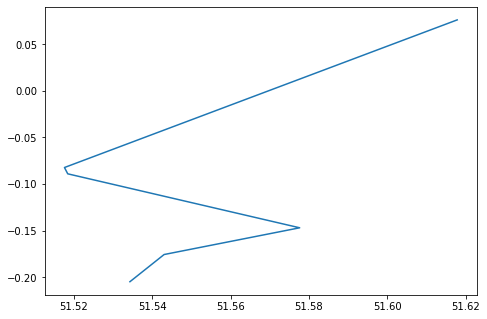

In [185]:
import timeit

# ADD YOUR TEST CODE HERE
test = LondonRailwayMapper()
# print(test.minStops("Abbey Road", "Abbey Wood"))
# print(test.minStops("Baker Street", "North Wembley")) # should be 6

# print(test.minDistance("Baker Street", "North Wembley"))
# print(test.minDistance("Abbey Road", "Abbey Wood"))

test.newRailwayLine(["Queens Park", "Chigwell", "Moorgate", "Swiss Cottage", "Liverpool Street", "Highgate"])
# test.newRailwayLine(['Abbey Road', 'Barbican', 'Bethnal Green', 'Cambridge Heath', 'Covent Garden', 'Dollis Hill', 'East Finchley', 'Finchley Road and Frognal', 'Great Portland Street', 'Hackney Wick', 'Isleworth', 'Kentish Town West', 'Leyton', 'Marble Arch', 'North Wembley', 'Old Street', 'Pimlico', 'Queens Park', 'Richmond', 'Shepherds Bush', 'Tottenham Hale', 'Uxbridge', 'Vauxhall', 'Wapping'])
# test.newRailwayLine(['Finchley Central' , 'Tottenham Hale' , 'Stamford Hill' , 'Whitechapel' , 'Canada Water' , 'Borough' , 'Brixton' , 'Imperial Wharf' , 'Hackney Downs' , 'Alperton' , 'Kenton'])

The cell below exemplifies the test code I will invoke on your submission. Do NOT modify it. 

In [88]:
# DO NOT MODIFY THIS CELL

import timeit

testMapper = LondonRailwayMapper()

#
# testing the loadStationsAndLines() API 
#
starttime = timeit.default_timer()
testMapper.loadStationsAndLines()
endtime = timeit.default_timer()
print("\nExecution time to load:", round(endtime-starttime,3))

#
# testing the minStops() and minStops() API on a sample of from/to station pairs  
#
fromList = ["Baker Street", "Epping", "Canonbury", "Vauxhall"]
toList = ["North Wembley", "Belsize Park", "Balham", "Leytonstone"]

for i in range(len(fromList)):
    starttime = timeit.default_timer()
    stops = testMapper.minStops(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("\nExecution time minStops:", round(endtime-starttime,3))

    starttime = timeit.default_timer()
    dist = testMapper.minStops(fromList[i], toList[i])
    endtime = timeit.default_timer()
    print("Execution time minDistance:", round(endtime-starttime,3))

    print("From", fromList[i], "to", toList[i], "in", stops, "stops and", dist, "miles")  
    
#
# testing the newRailwayLine() API on a small list of stations  
#
stationsList = ["Queens Park", "Chigwell", "Moorgate", "Swiss Cottage", "Liverpool Street", "Highgate"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))

#
# testing the newRailwayLine() API on a big list of stations  
#
stationsList = ["Abbey Road", "Barbican", "Bethnal Green", "Cambridge Heath", "Covent Garden", "Dollis Hill", "East Finchley", "Finchley Road and Frognal", "Great Portland Street", "Hackney Wick", "Isleworth", "Kentish Town West", "Leyton", "Marble Arch", "North Wembley", "Old Street", "Pimlico", "Queens Park", "Richmond", "Shepherds Bush", "Tottenham Hale", "Uxbridge", "Vauxhall", "Wapping"]

starttime = timeit.default_timer()
newLine = testMapper.newRailwayLine(stationsList)
endtime = timeit.default_timer()

print("\n\nStation list", stationsList)
print("New station line", newLine)
print("Total track length from", newLine[0], "to", newLine[len(newLine)-1], ":", testMapper.minDistance(newLine[0], newLine[len(newLine)-1]), "miles")
print("Execution time newLine:", round(endtime-starttime,3))


Execution time to load: 0.008
398
604
200
595
416
458
23
['North Wembley', 'Wembley Central', 'Euston', 'Warren Street', 'Oxford Circus', 'Regents Park', 'Baker Street']

Execution time minStops: 0.001
398
604
200
595
416
458
23
['North Wembley', 'Wembley Central', 'Euston', 'Warren Street', 'Oxford Circus', 'Regents Park', 'Baker Street']
Execution time minDistance: 0.001
From Baker Street to North Wembley in 6 stops and 6 miles
47
109
91
200
319
206
342
527
337
339
488
503
644
82
348
158
555
196
['Belsize Park', 'Chalk Farm', 'Camden Town', 'Euston', 'Kings Cross St. Pancras', 'Farringdon', 'Liverpool Street', 'Stratford', 'Leyton', 'Leytonstone', 'Snaresbrook', 'South Woodford', 'Woodford', 'Buckhurst Hill', 'Loughton', 'Debden', 'Theydon Bois', 'Epping']

Execution time minStops: 0.002
47
109
91
200
319
206
342
527
337
339
488
503
644
82
348
158
555
196
['Belsize Park', 'Chalk Farm', 'Camden Town', 'Euston', 'Kings Cross St. Pancras', 'Farringdon', 'Liverpool Street', 'Stratford',